# Spaceship Titanic Challenge

## Predict whether a passenger has been transported to a different dimension! 

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os

In [2]:
os.listdir('data/')

['test.csv', 'train.csv', 'sample_submission.csv']

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## Basic EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


There are quite some missing values and a lot of categorical/binary columns

In [5]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
len(df_train.loc[df_train.isna().any(axis=1), :])

2087

Every feature has missing values, and they are spread across the passengers. In total, >2000/8700 datapoints are affected, which is a huge number.

I need to carefully treat NaN values after doing some further explorations

Identify Missingness Patterns: Plotting data can help you identify patterns of missingness. For example, you might discover that missing values in one feature correspond to specific values in another feature.


In [7]:
df_train.duplicated(subset='PassengerId').sum()

0

In [8]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Massive outliers in terms of how much money has been spent in RoomService, FoodCOurt, Shopping, Spa, and Deck

Does high spending correlate with survival?

In [9]:
df_train.describe(include='object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


CryoSleep is binary, Homeplanet has 3 vals, Cabin needs to be split up, 3 destinations, binary VIP, unique names and IDs

In [10]:
df_train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [11]:
df_train['Transported'].value_counts() #Evenly split! Nice!

True     4378
False    4315
Name: Transported, dtype: int64

Change dtypes! HomePlanet: Categorical, CryoSleep: Binary, Cabin: Categorical (6500 different ones), Destination: Categorical, VIP: Binary, Name: string

## Adjust dtypes for EDA

In [12]:
# df_train
df_train['CryoSleep'] = df_train['CryoSleep'].astype(float) # df['CryoSleep'] = df['CryoSleep'].astype('bool').astype('int') does not preserve the NaNs!!
df_train['VIP'] = df_train['VIP'].astype(float)
df_train['Transported'] = df_train['Transported'].astype(int)
# Passenger Names are not significant to predict the survival of a passenger
df_train.drop('Name', axis=1, inplace=True)

# df_test
df_test['CryoSleep'] = df_test['CryoSleep'].astype(float)
df_test['VIP'] = df_test['VIP'].astype(float)
df_test.drop('Name', axis=1, inplace=True)

## Visualizations

<Axes: >

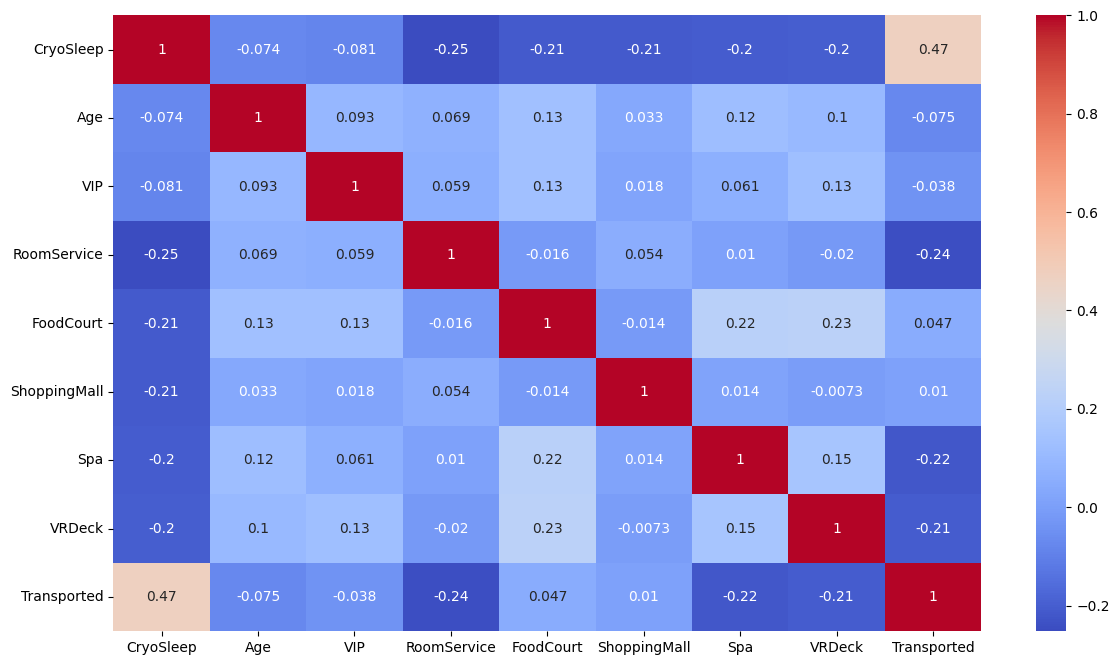

In [13]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')

CryoSleep and Transported are correlated. Also, Spendings in Room Service, Spa, and VR Deck do have correlations

<Axes: xlabel='CryoSleep', ylabel='count'>

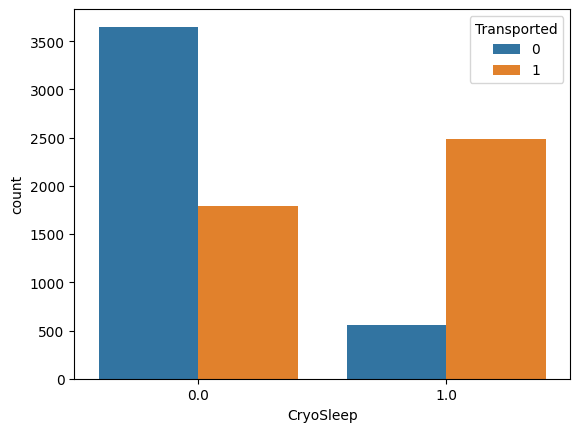

In [14]:
# have a look at Transported and CryoSleep with sns
sns.countplot(x='CryoSleep', data=df_train, hue='Transported')

CryoSleep is a good indicator for Transported! If Cryosleep is 0, chances are higher that Transported is 0 too. Maybe useful information for filling missing values

<Axes: xlabel='RoomService', ylabel='Count'>

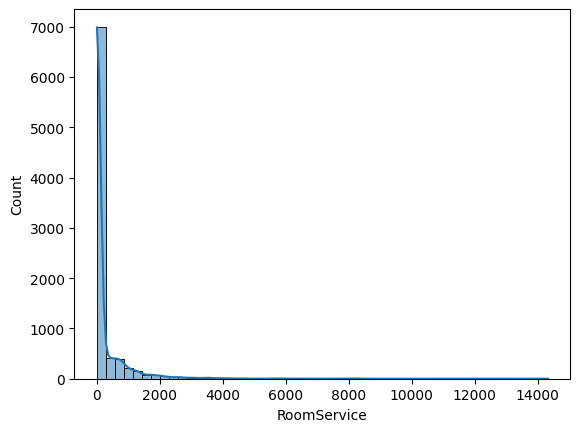

In [15]:
sns.histplot(x='RoomService', data=df_train, bins=50, kde=True)

Highly skewed. Most people have not spent anything. It probably makes sense to see what happened to those few people who have spent a lot

<Axes: ylabel='Frequency'>

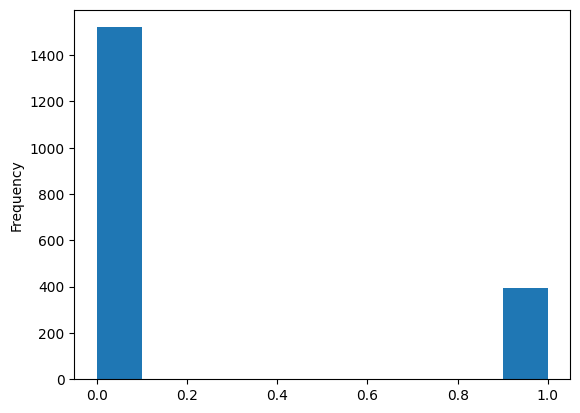

In [16]:
df_train.loc[df_train['RoomService'] > 100, 'Transported'].plot(kind='hist')

If passengers have paid money in Spa, Deck, and RoomService, they are likely to not being transported. 

This tendency grows more obvious the more the passenger has paid.  it's almost guaranteed that they are not transported when they spend like 1000 USD. Interesting!

In [17]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

<Axes: xlabel='VIP', ylabel='count'>

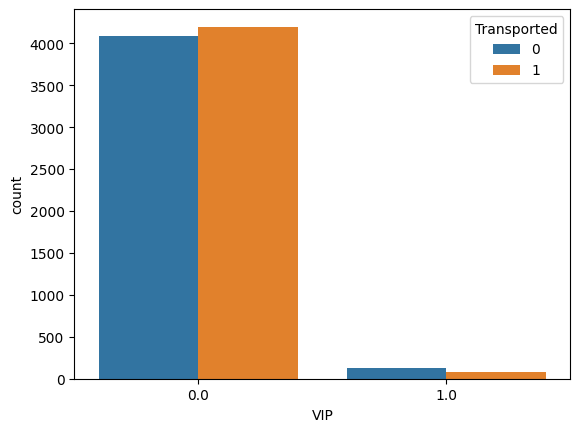

In [18]:
sns.countplot(x='VIP', data=df_train, hue='Transported')

VIP Tickets do not determine whether you are transported or not

<Axes: xlabel='HomePlanet', ylabel='count'>

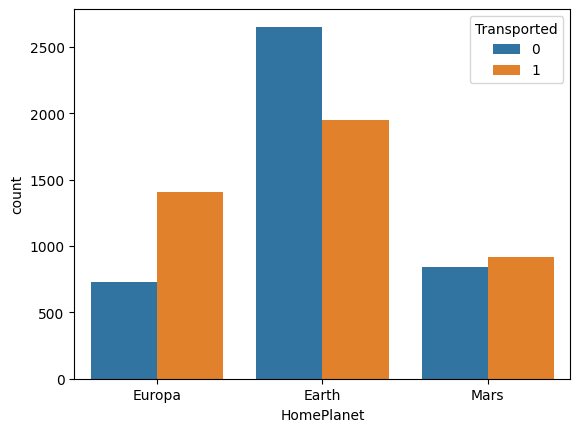

In [19]:
sns.countplot(x='HomePlanet', data=df_train, hue='Transported')

Not incredibly clear either.

<Axes: xlabel='Destination', ylabel='count'>

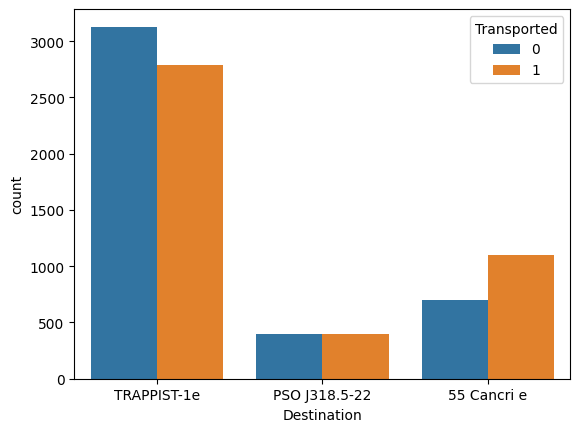

In [20]:
sns.countplot(x='Destination', data=df_train, hue='Transported')

Destination does not determine whether you are transported or not.

<Axes: xlabel='Age', ylabel='Count'>

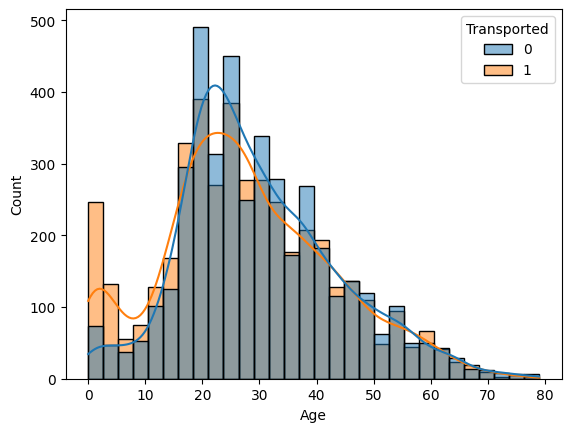

In [21]:
sns.histplot(x='Age', data=df_train, bins=30, kde=True, hue='Transported')

Higher chance of being transported if you are below 10, especially a baby, apparently. You are slightly safer if you are in your 20s

These are all correlations though, not causations

<Axes: xlabel='Transported', ylabel='RoomService'>

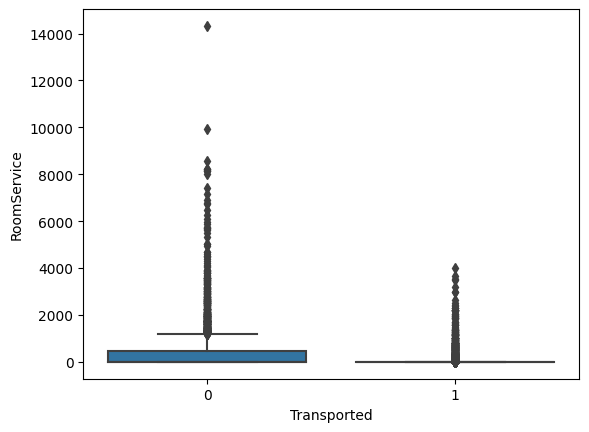

In [22]:
sns.boxplot(x='Transported', y='RoomService', data=df_train)

<Axes: xlabel='Transported', ylabel='VRDeck'>

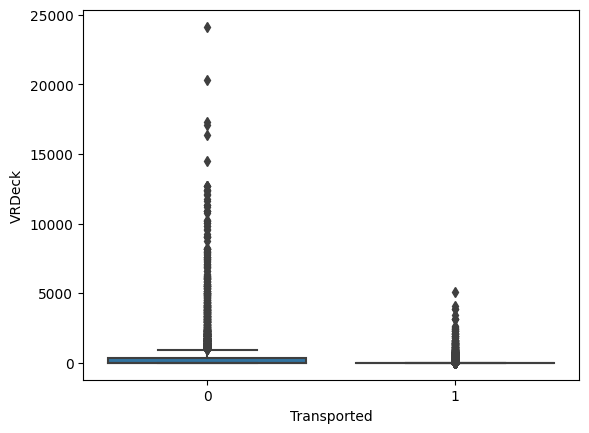

In [23]:
sns.boxplot(x='Transported', y='VRDeck', data=df_train)

<Axes: xlabel='Transported', ylabel='Spa'>

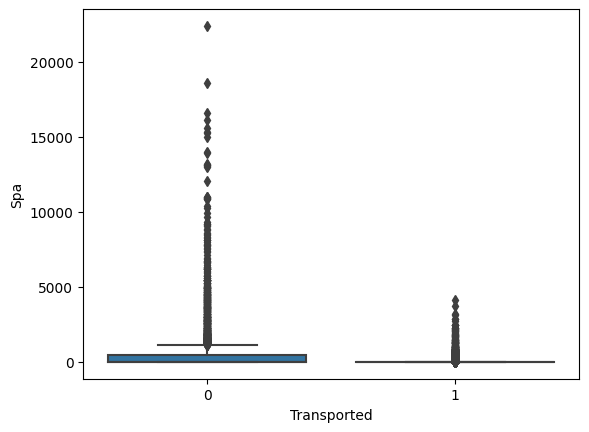

In [24]:
sns.boxplot(x='Transported', y='Spa', data=df_train)

In [25]:
from data_preprocessing import rmv_outliers
df_train = rmv_outliers(df_train, 'RoomService', 10000)
df_train = rmv_outliers(df_train, 'VRDeck', 18000)
df_train = rmv_outliers(df_train, 'Spa', 18000)

Only one missing is cabin and ID, which need to be feature engineered first

## Feature Engineering

ID indicates which group you were travelling with. Let's split that to two features. Then, we can find out who is traveling in a group and what size the group has

Cabin: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. Let's split that to three features

In [26]:
from data_preprocessing import feat_eng_cabin, feat_eng_passenger_id, imp_missing, encoding

# cabin is split in 3 different features (deck, cabin number, side)
df_train = feat_eng_cabin(df_train)
df_test = feat_eng_cabin(df_test)

# passenger id is split in 2 different features (passenger group, passenger ID), then the size of each group is derived and used as a new feature
df_train = feat_eng_passenger_id(df_train)
df_test = feat_eng_passenger_id(df_test)

In [27]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNo,CabinSide,GroupSize
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,1.0,1
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,0.0,1
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,0.0,2
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,0.0,2
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,0.0,1


In [28]:
df_train['Deck'].value_counts()

F    2607
G    2387
E     828
B     737
C     704
D     443
A     246
T       5
Name: Deck, dtype: int64

Most people are traveling in deck category F or G

In [29]:
df_train['CabinSide'].value_counts() #Evenly distributed, and it's binary!

0.0    4021
1.0    3936
Name: CabinSide, dtype: int64

<Axes: xlabel='Deck', ylabel='count'>

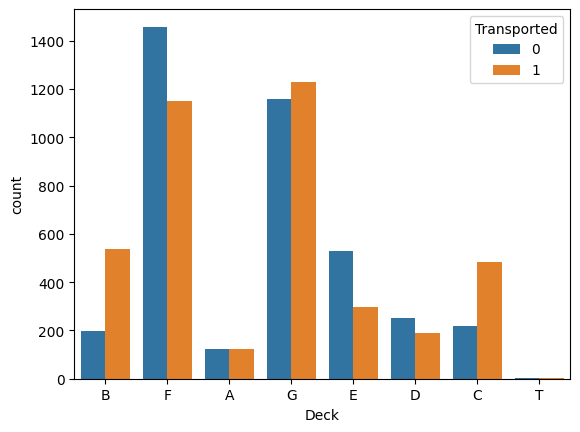

In [30]:
sns.countplot(x='Deck', data=df_train, hue='Transported')

CAtegory B and C are more likely to be transported

<Axes: xlabel='CabinSide', ylabel='count'>

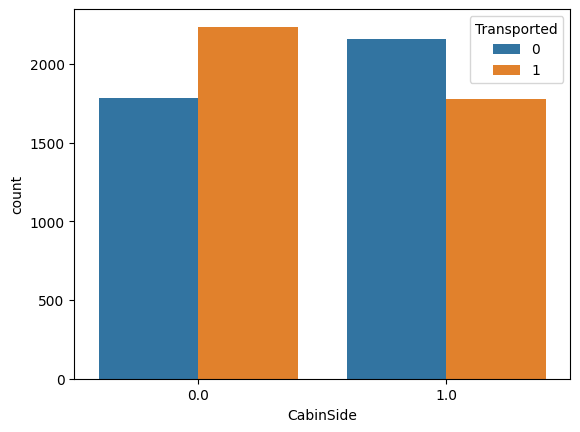

In [31]:
sns.countplot(x='CabinSide', data=df_train, hue='Transported')

Cabin Side P (=1) is slightly better..?

In [32]:
# Check out GroupSize

<Axes: xlabel='GroupSize', ylabel='count'>

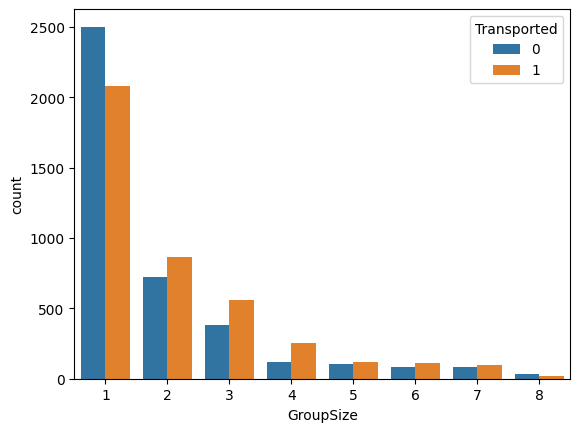

In [33]:
sns.countplot(x='GroupSize', data=df_train, hue='Transported')

Most people travel alone. GroupSize is not a crystal clear indicator for being transported. However, if you are traveling in a group, you are more likely to not being transported into space

## Missing Values
### Due to the significant amount, consider column-specific filling

### What I have found out so far, which can help to impute values: 
- If Cryosleep is 0, chances are higher that Transported is 0 too. 
- If passengers have paid a lot (more than 1000 dollars) in Spa, Deck, and RoomService, it's almost guaranteed that they are not transported. Interesting!
- Higher chance of being transported if you are below 10, especially a baby, apparently. You are safer if you are in your 20s
- Most people are traveling in deck category F or G
- CAtegory B and C are more likely to be transported
- Cabin Side P is slightly better
- Traveling in Groups helps

Let's consider categorical and numerical columns separately

In [34]:
df_train.select_dtypes(['float64','int64']).columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'CabinNo', 'CabinSide', 'GroupSize'],
      dtype='object')

In [35]:
df_train.select_dtypes('object').columns

Index(['HomePlanet', 'Destination', 'Deck'], dtype='object')

In [36]:
# missing values are imputed
df_train = imp_missing(df_train)
df_test = imp_missing(df_test)

In [37]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNo,CabinSide,GroupSize
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0.0,1.0,1.0
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,F,0.0,0.0,1.0
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,A,0.0,0.0,2.0
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,A,0.0,0.0,2.0
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,F,1.0,0.0,1.0


Note: We could perform column-specific imputation manually as well

In [38]:
df_train.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
CabinNo         0
CabinSide       0
GroupSize       0
dtype: int64

## Encoding Categorical Variables

In [39]:
df_train = encoding(df_train)
df_test = encoding(df_test)

## Modeling

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [71]:
logreg = make_pipeline(StandardScaler(), LogisticRegression())
xgb = XGBClassifier()
rf = RandomForestClassifier()
nvbs = GaussianNB()

estimators = {"LogisticRegression": logreg, "XGBClassifier": xgb, "RandomForestClassifier": rf, "GaussianNB": nvbs}

In [72]:
cross = KFold(n_splits=5, shuffle=True, random_state=42)

for name, estimator in estimators.items():
    acc = cross_val_score(estimator=estimator, X=df_train.drop('Transported', axis=1), y=df_train['Transported'], cv=cross, scoring='accuracy').mean()
    print(f"Accuracy from Crossvalidation for {name} is {acc}")

Accuracy from Crossvalidation for LogisticRegression is 0.7950890116635974
Accuracy from Crossvalidation for XGBClassifier is 0.8056476365868631
Accuracy from Crossvalidation for RandomForestClassifier is 0.8011049723756904
Accuracy from Crossvalidation for GaussianNB is 0.751135666052793


## XGBoost and RandomForest are slightly superior. 
### Let's have a look at the Random Forest in more detail

In [105]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Transported', axis=1)
y = df_train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', verbose=1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81       792
         1.0       0.84      0.77      0.80       837

    accuracy                           0.80      1629
   macro avg       0.81      0.81      0.80      1629
weighted avg       0.81      0.80      0.80      1629



In [89]:
confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[663, 129],
       [201, 636]])

In [86]:
impo = rf.feature_importances_ # Most important ones: second and ninth
feats = X_train.columns.tolist()

feat_df = pd.DataFrame({'Feature': feats, 'Importance': impo})
feat_df

,Feature,Importance
0,CryoSleep,0.096845
1,Age,0.122329
2,VIP,0.002080
3,RoomService,0.096178
4,FoodCourt,0.082112
5,ShoppingMall,0.065939
6,Spa,0.098080
7,VRDeck,0.094311
8,CabinNo,0.157003
9,CabinSide,0.026487


Interestingly, Age (which was not really correlated to the label) and Cabin No were the most important features 

## Submission

In [93]:
submi = rf.predict(df_test)

In [97]:
submi = pd.Series(submi.astype(bool), name='Transported')

In [98]:
submi

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276    False
Name: Transported, Length: 4277, dtype: bool

In [99]:
submi.value_counts()

False    2282
True     1995
Name: Transported, dtype: int64